## **Before you start**

Make a copy of this Colab by clicking on File > Save a Copy in Drive

After making a copy, add your student id, last name, and first name to the title.

# Classifying Images


This exercise is about classifying images - just like Lab 1. Each input is a grid of pixel values and each output is a label from a small set of labels. You will start with a simple binary classifier and finish with a multi-class one.

### Grading

This assignment is worth a total of 100 points.

In [ ]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style='darkgrid')  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics

## Understanding the data
We'll be using the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. This consists of 70,000 grayscale images (28x28). Each image is associated with 1 of 10 classes. The dataset was split by the creators; there are 60,000 training images and 10,000 test images. 

Fashion MNIST classes:
* T-shirt/top
* Trouser
* Pullover
* Dress
* Coat
* Sandal
* Shirt
* Sneaker
* Bag
* Ankle boot

Before doing anything, let's make sure we understand what we're working with. 

### Load the data
Tensorflow includes a growing [library of datasets](https://www.tensorflow.org/datasets/catalog/overview) and makes it easy to load them in numpy arrays.

In [ ]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

np.random.seed(0) # For reproducibility purposes

# Shuffle the order of the training examples.
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)

X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

### Basic Analysis
Notice that `X_train`, `Y_train`, `X_test`, and `Y_test` are all numpy arrays. Let's print their shapes to confirm.

In [ ]:
# Show the data shapes.
print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)

X_train.shape: (60000, 28, 28)
Y_train.shape: (60000,)
X_test.shape: (10000, 28, 28)
Y_test.shape: (10000,)


Notice that there are 60,000 instances in `X_train`. Each of these is a grayscale image represented by an 28-by-28 array of grayscale pixel values between 0 and 255 (the larger the value, the lighter the pixel). Before we continue, let's apply linear scaling to our pixel values, so they all fall between 0 and 1.

In [ ]:
# Pixel values range from 0 to 255. To normalize the data, we just need to 
# divide all values by 255.
X_train = X_train / 255
X_test = X_test / 255

In class, we talked about features - properties that characterize our data. Here, we treat **every pixel value as a separate feature**, so each input example has 28x28 (784) features!

Fashion MNIST images have one of 10 possible labels (shown above). Since the labels are indices 0-9, let's keep a list of (string) names for convenience.

In [ ]:
label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Show the first 5 training labels.
print('First 5 label values:', Y_train[0:5])
print('Mapped to their names:', [label_names[i] for i in Y_train[0:5]])


First 5 label values: [0 2 6 5 2]
Mapped to their names: ['t-shirt', 'pullover', 'shirt', 'sandal', 'pullover']


Next let's use the `imshow` function to look at the first few images in the training set.

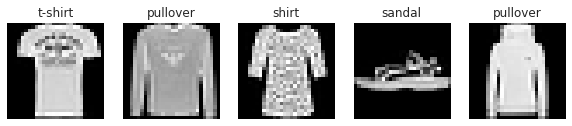

In [ ]:
# Create a figure with subplots. This returns a list of object handles in axs
# which we can use populate the plots.
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
for i in range(5):
  image = X_train[i]
  label = Y_train[i]
  label_name = label_names[label]
  axs[i].imshow(image, cmap='gray')  # imshow renders a 2D grid
  axs[i].set_title(label_name)
  axs[i].axis('off')
plt.show()

## Problem Definition: Sneaker Classifier
There are many things we can do with this dataset. Following our lectures, let's start with binary classification. We'll use logistic regression to build a sneaker classifier. Our positive examples ($y=1$) will be sneaker images (class 7) and our negative examples ($y=0$) will be all other images.

The idea is that our model, given an image $x$, will produce $\hat{y}$, the probability that $x$ is a sneaker.


### Logistic Regression

Recall that logistic regression is an application of the logistic (sigmoid) function to the linear regression model:

\begin{equation}
y=\frac{1}{1+e^{-z}} 
\end{equation}

<center>
<img src="https://developers.google.com/machine-learning/crash-course/images/SigmoidFunction.png" alt="Sigmoid Function" width="45%"/>
</center>

where:

\begin{equation}
z= b + w_1x_1 + w_2x_2 + ... + w_nx_n
\end{equation}

In order to map a logistic regression value to a label, a classification threshold needs to be defined. A value above or equal to that threshold indicates that the input should be classified as positive (e.g., sneaker); a value below the threshold indicates that the input should be classified as negative (e.g., non-sneaker).  




#### Log Loss

The loss function for logistic regression is Log Loss (also known as binary cross-entropy), which is defined as follows: 

\begin{equation}
-\frac{1}{|Y|} \sum_{y_i \in Y}y_i log(\hat{y}_i) + (1−y_i)log(1−\hat{y}_i)
\end{equation}

Remember that $y$ is either 0 or 1, so either the left term or the right term is active for each example.

Log loss is differentiable and convex, and as we have seen, the gradient turns out to be identical to that of MSE in linear regression.

### Data Preprocessing
Before we continue, we need to prepare the data for this binary classification task. We'll map sneaker image laebls to 1 (the positive class) and all other images to 0 (the negative class).

Programming note: Numpy allows us to perform what is called [boolean array indexing](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#boolean-array-indexing)
This means that a numpy array $A$ can be indexed using a boolean array $B$
as follows: $A[B]$.
We'll take advantage of this type of indexing to prepare the labels for our binary classification task below.

In [ ]:
# Make copies of the original labels.
Y_train_binary = np.copy(Y_train)
Y_test_binary = np.copy(Y_test)

# Update labels: 1 for sneaker images; 0 for the rest.
# Note that a boolean array is created when Y_train_binary != 7 is evaluated.
Y_train_binary[Y_train_binary != 7] = 0.0 
Y_train_binary[Y_train_binary == 7] = 1.0
Y_test_binary[Y_test_binary != 7] = 0.0
Y_test_binary[Y_test_binary == 7] = 1.0
# Cool, right?

### Baseline

When dealing with classification problems, a simple, but useful baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

Our training dataset consists of 6,000 sneaker examples (10%), and 54,000 non-sneaker images (90%), so our majority class baseline classifies everything as *non-sneaker*, and will have an accuracy of 90%. We will see if we can beat this baseline with k-NN.

In [ ]:
print('Number of sneaker images in training set:', (Y_train_binary == 1).sum())
print('Number of non-sneaker images in training set:', (Y_train_binary == 0).sum())

Number of sneaker images in training set: 6000
Number of non-sneaker images in training set: 54000


#### Exercise 1 (25 points)

Implement a function that computes the Log Loss (binary cross-entropy) metric and use it to evaluate our baseline on both the train and test data. Use 0.1 as the predicted probability for your baseline (reflecting what we know about the original distribution of classes in our dataset).

In [ ]:
def log_loss(Y_true, Y_pred):
  """Returns the binary log loss for a list of labels and predictions.

  Args:
    Y_true: A list of (true) labels (0 or 1)
    Y_pred: A list of corresponding predicted probabilities

  Returns:
    Binary log loss
  """

  # YOUR CODE HERE
  loss = -np.mean(Y_true*(np.log(Y_pred)) - (1-Y_true) * np.log(1-Y_pred))
  return loss


In [ ]:
# Evaluate baseline on both the train and test data. Use 0.1 as the predicted probability for your baseline
print(log_loss(Y_train_binary, 0.10))

0.13543404520736085


## Binary Logistic Regression Classification
Now that we have our data ready, let's build our binary classifier! 

Once again, we will use Tensorflow/Keras to build our logistic regression model. 

In [ ]:
def build_model(input_shape, learning_rate=0.1):
  """Build a TF logistic regression model using Keras.

  Args:
    input_shape: The shape of the model's input. 
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # Reset TF and random seed (for reproducible results).
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Use the Keras Sequential API as before.
  model = keras.Sequential()

  # Keras layers can do pre-processing. This layer will take our 28x28 images
  # and flatten them into vectors of size 784.
  model.add(keras.layers.Flatten(input_shape=input_shape))
  
  # This layer constructs the linear set of parameters for each input feature
  # (as well as a bias), and applies a sigmoid to the result. The result is
  # binary logistic regression.
  model.add(keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      use_bias=True,               # use a bias param
      activation='sigmoid'         # apply the sigmoid function!
  ))

  # We'll use mini-batch SGD and can specify the batch size later.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Compile the model.
  model.compile(loss='binary_crossentropy', 
                optimizer=optimizer, 
                metrics=[metrics.binary_accuracy])

  return model

Let's make sure we can build a model. Before training, the parameters of the model are initialized randomly (this is the default). While the untrained model won't make good predictions, we should still be able to pass data through it and get probability outputs.


In [ ]:
# Build the model. Notice that we are passing the shape of our images to
# the model, as Keras needs to know the dimension of the input.
model = build_model(input_shape=X_train[0].shape)

# Make a prediction for five inputs.
print(model.predict(X_train[0:5]))

[[0.24910647]
 [0.190254  ]
 [0.14809623]
 [0.48857784]
 [0.32321048]]


As expected, the outputs look like probabilities (in [0,1]). Once the model is trained, we hope that these predictions correspond to the probability that each input image is a sneaker.


### Training
Let's train the model. Note that we're using 10% of the training data as a *validation split*. This serves a similar purpose to our test data, allowing us to check for over-fitting during training. We don't use the test data here because we might run lots of experiments, and over time, we might adjust settings to improve results on the validation set. We want to preserve the purity of the test data so we can the cleanest possible evaluation at the end of the experimentation process.

In [ ]:
model = build_model(input_shape=X_train[0].shape, learning_rate=0.1)

# Fit the model.
history = model.fit(
  x = X_train,          # our binary training examples
  y = Y_train_binary,   # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

Epoch 1/5
844/844 [==============================] - 2s 2ms/step - loss: 0.0910 - binary_accuracy: 0.9652 - val_loss: 0.0782 - val_binary_accuracy: 0.9687
Epoch 2/5
844/844 [==============================] - 2s 2ms/step - loss: 0.0668 - binary_accuracy: 0.9759 - val_loss: 0.0687 - val_binary_accuracy: 0.9737
Epoch 3/5
844/844 [==============================] - 1s 2ms/step - loss: 0.0602 - binary_accuracy: 0.9786 - val_loss: 0.0645 - val_binary_accuracy: 0.9748
Epoch 4/5
844/844 [==============================] - 1s 2ms/step - loss: 0.0565 - binary_accuracy: 0.9798 - val_loss: 0.0620 - val_binary_accuracy: 0.9767
Epoch 5/5
844/844 [==============================] - 1s 2ms/step - loss: 0.0543 - binary_accuracy: 0.9803 - val_loss: 0.0605 - val_binary_accuracy: 0.9765


,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.091040,0.965204,0.078212,0.968667
1,0.066774,0.975870,0.068692,0.973667
2,0.060177,0.978556,0.064469,0.974833
3,0.056494,0.979796,0.062037,0.976667
4,0.054269,0.980315,0.060491,0.976500


Good news! Both training accuracy and validation accuracy are near 98\% (and the loss should be quite a bit lower than your baseline loss calculation above). This means the classifier is quite a bit better than the majority-class baseline.


### Inference

Let's use the trained model to predict probabilities for the test data. We can use `predict` to run *inference*. The probabilities output by the model will be the probability of the positive class.


In [ ]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_predictions = model.predict(X_test).flatten()
print(test_predictions.shape)
print(test_predictions)

(10000,)
[0. 0. 0. ... 0. 0. 0.]


Now that we have probabilities for all images in `X_test`, let's evaluate how well the model performed on our test set. 


### Evaluation
To turn probabilities into binary predictions, we need to choose a classification threshold. A probability greater than or equal to threshold indicates class *sneaker*, while a value less than the threshold indicates class *non-sneaker*. Once we have binary predictions, we can evaluate performance with some different metrics.

A **true positive** is an outcome where the model correctly predicts the positive class. Similarly, a **true negative** is an outcome where the model correctly predicts the negative class.

A **false positive** is an outcome where the model incorrectly predicts the positive class. And a **false negative** is an outcome where the model incorrectly predicts the negative class.

Using these, we can construct a **confusion matrix**, a table that summarizes performance using these 4 result categories.

|                     | Sneaker (Actual)    | Non-Sneaker (Actual) |
|---------------------|-----------------|------------------|
| **Sneaker (Predicted)**     | Number of True Positives  | Number of False Positives  |
| **Non-Sneaker (Predicted)** | Number of False Negatives | Number of True Negatives   |


**Accuracy** is the fraction of examples our model classified correctly (correct / total):

\begin{equation}
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
\end{equation}

**Precision** is the proportion of positive predictions that were actually correct:

\begin{equation}
Precision = \frac{TP}{TP + FP}
\end{equation}

**Recall** is the proportion of actual positives that were predicted correctly:

\begin{equation}
Recall = \frac{TP}{TP + FN}
\end{equation}

Changing the threshold will change precision and recall, typically with a trade-off: improving precision reduces recall (and vice-versa).

#### Exercise 2 (25 points)


Do the following for each of these classification thresholds [0.1, 0.3, 0.5, 0.7, 0.9] using the `test_predictions` (predicted probabilities) and `Y_test_binary` (actual labels):

1.   Compute and print counts of [tp, tn, fp, fn], corresponding to the confusion matrix.
2.   Compute and print the accuracy, precision, and recall.

**Feel free to reuse your solution for Lab 1 and/or use sklearn**

In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate(Y_true, Y_pred, threshold):
  Y_pred = (Y_pred >= threshold) * 1.0

  tp = np.sum(np.logical_and(Y_pred == 1, Y_true == 1))  
  tn = np.sum(np.logical_and(Y_pred == 0, Y_true == 0))
  fp = np.sum(np.logical_and(Y_pred == 1, Y_true == 0))
  fn = np.sum(np.logical_and(Y_pred == 0, Y_true == 1))

  acc = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  print("threshold:",threshold)
  
  print("\t tp: %d tn: %d fp: %d fn: %d: "%(tp, tn, fp, fn))  
  print("\t acc: %f precision: %f recall: %f"%(acc, precision, recall))
  print()

for threshold in [0.1, 0.3, 0.5, 0.7, 0.9]:
  evaluate(Y_test_binary, test_predictions, threshold)

threshold: 0.1
	 tp: 967 tn: 8768 fp: 232 fn: 33: 
	 acc: 0.973500 precision: 0.806505 recall: 0.967000

threshold: 0.3
	 tp: 966 tn: 8768 fp: 232 fn: 34: 
	 acc: 0.973400 precision: 0.806344 recall: 0.966000

threshold: 0.5
	 tp: 966 tn: 8768 fp: 232 fn: 34: 
	 acc: 0.973400 precision: 0.806344 recall: 0.966000

threshold: 0.7
	 tp: 966 tn: 8769 fp: 231 fn: 34: 
	 acc: 0.973500 precision: 0.807018 recall: 0.966000

threshold: 0.9
	 tp: 966 tn: 8769 fp: 231 fn: 34: 
	 acc: 0.973500 precision: 0.807018 recall: 0.966000



## Multiclass Classification

We are now ready for the full multi-class case. Instead of using `Y_train_binary` and `Y_test_binary`, we'll use the original labels `Y_train` and `Y_test`. 


### Cross-Entropy Loss

Recall the log loss function (above), where $y$ is either 0 or 1:

\begin{equation}
-y \log(\hat{y}) + (1−y)\log(1−\hat{y})
\end{equation}

The general form for cross-entropy is used when $y$ is assumed to be a label vector with a 1 in the index of the true label and a 0 everywhere else: $y=[0,0,0,0,0,0,0,1,0,0]$ implies a label of "sneaker" in this dataset (the 7th label). Accordingly, $\hat{y}$ is a vector of predicted probabilities. Then the cross-entropy loss is simply:

\begin{equation}
-\sum_{j} y_j \log(\hat{y}_j)
\end{equation}

As in the binary case, this summation will have exactly 1 non-zero term where the true label $y_j=1$.

Note that this formulation is using a *dense* representation of the label. The corresponding *sparse* representation would use the non-zero index directly ($y=7$).

#### Exercise 3 (25 points)

Fill in the NotImplemented parts of the `build_softmax_model` function below. You will need to make the following changes to generalize the binary case to the multi-class case:
* The output will include 10 probabilities instead of 1.
* Use a softmax function instead of a sigmoid to normalize output scores to a probability distribution.
* Use a [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss instead of binary_crossentropy. Note that "sparse" refers to the use of a sparse index (e.g. 7) to indicate the label rather than a dense vector (e.g. [0,0,0,0,0,0,0,1,0,0]).

Check that training works below.

In [ ]:
# Replace NotImplemented code below
def build_softmax_model(input_shape, n_classes, learning_rate=0.1):
  """Build a TF logistic regression model using Keras.

  Args:
    input_shape: The shape of the model's input. 
    n_classes: Number of classes in dataset
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=input_shape))
  model.add(keras.layers.Dense(
      units=10,
      activation='softmax'
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                optimizer=optimizer, 
                metrics=['accuracy'])
  return model

### Training 

Train your model. If implemented correctly, you should reach validation accuracy 0.838 after 5 epochs.

In [ ]:
softmax_model = build_softmax_model(X_train[0].shape, len(label_names), 0.1)

softmax_history = softmax_model.fit(
  x = X_train,
  y = Y_train,
  epochs=5,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

softmax_history = pd.DataFrame(softmax_history.history)
display(softmax_history)

Epoch 1/5
844/844 [==============================] - 2s 2ms/step - loss: 0.6363 - accuracy: 0.7854 - val_loss: 0.5491 - val_accuracy: 0.8155
Epoch 2/5
844/844 [==============================] - 2s 2ms/step - loss: 0.4941 - accuracy: 0.8315 - val_loss: 0.5089 - val_accuracy: 0.8277
Epoch 3/5
844/844 [==============================] - 2s 2ms/step - loss: 0.4661 - accuracy: 0.8417 - val_loss: 0.4870 - val_accuracy: 0.8313
Epoch 4/5
844/844 [==============================] - 2s 2ms/step - loss: 0.4506 - accuracy: 0.8446 - val_loss: 0.5234 - val_accuracy: 0.8203
Epoch 5/5
844/844 [==============================] - 2s 2ms/step - loss: 0.4409 - accuracy: 0.8491 - val_loss: 0.4758 - val_accuracy: 0.8380


,loss,accuracy,val_loss,val_accuracy
0,0.636347,0.785444,0.549123,0.815500
1,0.494096,0.831481,0.508859,0.827667
2,0.466115,0.841685,0.487049,0.831333
3,0.450590,0.844556,0.523418,0.820333
4,0.440874,0.849111,0.475797,0.838000


### Inference

As in the binary case, we can use our trained model to predict probabilities for new examples. Now that we have an output distribution over 10 class, the `predict` function will produce the corresponding 10 probabilities. We can use `argmax` to select the index of the highest probability.

In [ ]:
# Recall that model.predict gives a vector of probabilities for each x.
# Get labels by taking the argmax -- the index with the largest probability.
softmax_test_predictions = np.argmax(softmax_model.predict(X_test), axis=-1)
print(softmax_test_predictions)

[9 2 1 ... 8 1 5]


### Evaluation

Overall accuracy gives a very limited picture of the model's performance. A confusion matrix gives a much deeper summary.

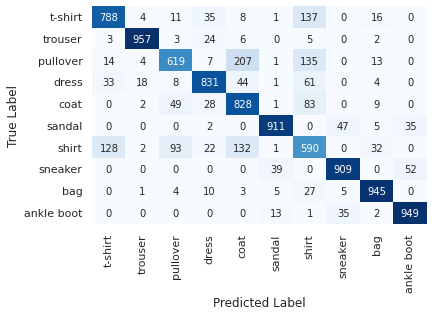

In [ ]:
# Create a confusion matrix as a 2D array.
softmax_confusion_matrix = tf.math.confusion_matrix(Y_test,
                                                    softmax_test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(softmax_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

## Feed Forward Neural Network Classification

We're now ready to build our first neural network. This is as easy as adding "hidden" layers to our model structure.

### Exercise 4 (25 points)

Fill in the implementation of the `build_ffnn_softmax_model` function below. This will be almost identical to `build_softmax_model` (above), but should include **2 hidden layers**, each with **128 units**, and each using a **relu activation**.

In [ ]:
def build_ffnn_softmax_model(input_shape, n_classes, learning_rate=0.1):
  """Build a TF feed-forward neural network model using Keras.

  Args:
    input_shape: The shape of the model's input. 
    n_classes: Number of classes in dataset
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = keras.Sequential()

  model.add(keras.layers.Flatten(input_shape=input_shape))
  #---------hidden layers----------
  model.add(keras.layers.Dense(
      units=128,
      activation='relu'
  ))
  model.add(keras.layers.Dense(
      units=128,
      activation='relu'
  ))
  #--------------------------------
  model.add(keras.layers.Dense(
      units=10,
      activation='softmax'
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                optimizer=optimizer, 
                metrics=['accuracy'])
  return model

### Training 

Train your model. If implemented correctly, you should reach validation accuracy 0.867 after 5 epochs.

In [ ]:
ffnn_softmax_model = build_ffnn_softmax_model(
    X_train[0].shape, len(label_names), 0.1)

ffnn_softmax_history = ffnn_softmax_model.fit(
  x = X_train,
  y = Y_train,
  epochs=5,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

ffnn_softmax_history = pd.DataFrame(ffnn_softmax_history.history)
display(ffnn_softmax_history)

Epoch 1/5
844/844 [==============================] - 4s 4ms/step - loss: 0.6009 - accuracy: 0.7847 - val_loss: 0.4809 - val_accuracy: 0.8270
Epoch 2/5
844/844 [==============================] - 3s 3ms/step - loss: 0.4206 - accuracy: 0.8478 - val_loss: 0.4448 - val_accuracy: 0.8400
Epoch 3/5
844/844 [==============================] - 3s 4ms/step - loss: 0.3768 - accuracy: 0.8629 - val_loss: 0.3845 - val_accuracy: 0.8618
Epoch 4/5
844/844 [==============================] - 3s 4ms/step - loss: 0.3482 - accuracy: 0.8713 - val_loss: 0.3758 - val_accuracy: 0.8637
Epoch 5/5
844/844 [==============================] - 3s 4ms/step - loss: 0.3290 - accuracy: 0.8778 - val_loss: 0.3585 - val_accuracy: 0.8672


,loss,accuracy,val_loss,val_accuracy
0,0.600926,0.784722,0.480891,0.827000
1,0.420649,0.847833,0.444823,0.840000
2,0.376807,0.862852,0.384479,0.861833
3,0.348246,0.871315,0.375776,0.863667
4,0.329026,0.877759,0.358489,0.867167


In [ ]:
ffnn_softmax_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


### Evaluation

Let's compare the confusion matrices for the linear model (softmax_model) and the neural network model (ffnn_softmax_model) to see which specific confusions are fixed by the improved model.

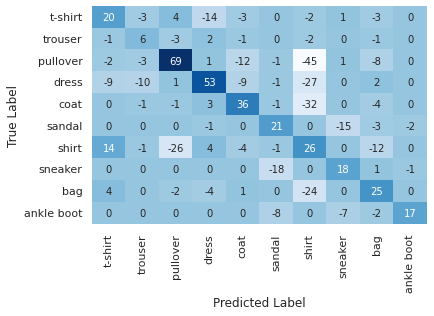

In [ ]:
ffnn_softmax_test_predictions = np.argmax(
    ffnn_softmax_model.predict(X_test), axis=-1)

# Create a confusion matrix as a 2D array.
ffnn_softmax_confusion_matrix = tf.math.confusion_matrix(
    Y_test, ffnn_softmax_test_predictions)

# Use a heatmap plot to display it.
diff_confusion_matrix = ffnn_softmax_confusion_matrix - softmax_confusion_matrix
ax = sns.heatmap(diff_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#### Exercise 5 (ungraded - 0 points - just for extra fun)

a. In this confusion matrix of differences, what do the diagonal values represent, and what do the off-diagonal values represent?

b. Which confused pair is most improved by the neural network model?

WRITE YOUR ANSWERS HERE

a.

b.


## Submission Instructions

1. File > Download .ipynb
2. Go to Blackboard, find the submission page, and upload the .ipynb file you just downloaded.